<a href="https://colab.research.google.com/github/PLUXINDUI/Ispm_course/blob/main/%D0%A3%D0%9F%D0%A1%D0%98%D0%A1/%22%D0%A3%D0%9F%D0%98%D0%A1_%D0%97%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%E2%84%964_%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B1%D0%B0%D0%B7%D1%8B_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85_%D0%B4%D0%BB%D1%8F_%D0%B8%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%BE%D0%B9_%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D1%8B_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Задание №4. Проектирование базы данных для информационной системы**

* **Таблица cars**

Содержит информацию о базовых моделях автомобилей, используемых в симуляции.

car_id — уникальный идентификатор автомобиля (первичный ключ).

model_name — название модели (например, «DrivAer Fastback»).

manufacturer — производитель (может быть «Generic» или «НАМИ»).

base_cx — базовый коэффициент лобового сопротивления.

base_cl — базовый коэффициент прижимной силы.

power_hp — мощность двигателя в лошадиных силах.

mass_kg — масса автомобиля в килограммах.

frontal_area — лобовая площадь в квадратных метрах.

car_type — тип кузова (fastback, notchback, estate и др.).

description — текстовое описание модели.

model_3d_path — путь к файлу 3D-модели (например, .stl или .obj).

* **Таблица element_types**

Является справочником типов аэродинамических элементов.

type_id — уникальный идентификатор типа (первичный ключ).

type_name — название типа (например, «Задний спойлер», «Диффузор», «Боковая юбка»).

* **Таблица aero_elements**

Хранит параметрическое описание каждого аэродинамического элемента.

element_id — уникальный идентификатор элемента (первичный ключ).

name — название элемента (например, «Спойлер Gurney Flap»).

type_id — ссылка на тип элемента из таблицы element_types (внешний ключ).

base_cx_effect — базовое изменение коэффициента лобового сопротивления при установке элемента.

base_cl_effect — базовое изменение коэффициента прижимной силы.

min_angle_deg — минимально допустимый угол установки (в градусах).

max_angle_deg — максимально допустимый угол установки.

default_angle_deg — угол по умолчанию.

size_factor_min — минимальный масштаб элемента (например, 0.5).

size_factor_max — максимальный масштаб (например, 1.5).

description — техническое описание элемента.

* **Таблица car_modifications**

Фиксирует, какие элементы установлены на конкретный автомобиль, и с какими настройками.

mod_id — уникальный идентификатор модификации (первичный ключ).

car_id — ссылка на автомобиль из таблицы cars (внешний ключ).

element_id — ссылка на элемент из таблицы aero_elements (внешний ключ).

angle_deg — фактический угол установки элемента.

size_factor — фактический масштаб элемента (1.0 — стандартный размер).

position_x, position_y, position_z — дополнительные параметры для 3D-позиционирования (опционально).

created_at — дата и время создания конфигурации.

* **Таблица simulation_cache**

Используется для кэширования результатов симуляции, чтобы избежать повторных вызовов нейросети для одинаковых конфигураций.

cache_id — уникальный идентификатор записи (первичный ключ).

car_id — ссылка на автомобиль (внешний ключ).

modification_hash — хеш-сумма (например, SHA256) от JSON-представления списка модификаций; обеспечивает уникальность конфигурации.

predicted_cx — итоговый коэффициент лобового сопротивления, предсказанный нейросетью.

predicted_cl — итоговый коэффициент прижимной силы.

max_speed_kmh — рассчитанная максимальная скорость (км/ч).

acceleration_0_100 — рассчитанное время разгона от 0 до 100 км/ч (секунды).

created_at — дата кэширования результата.

#### **4.2. Схема базы данных на MySQL**

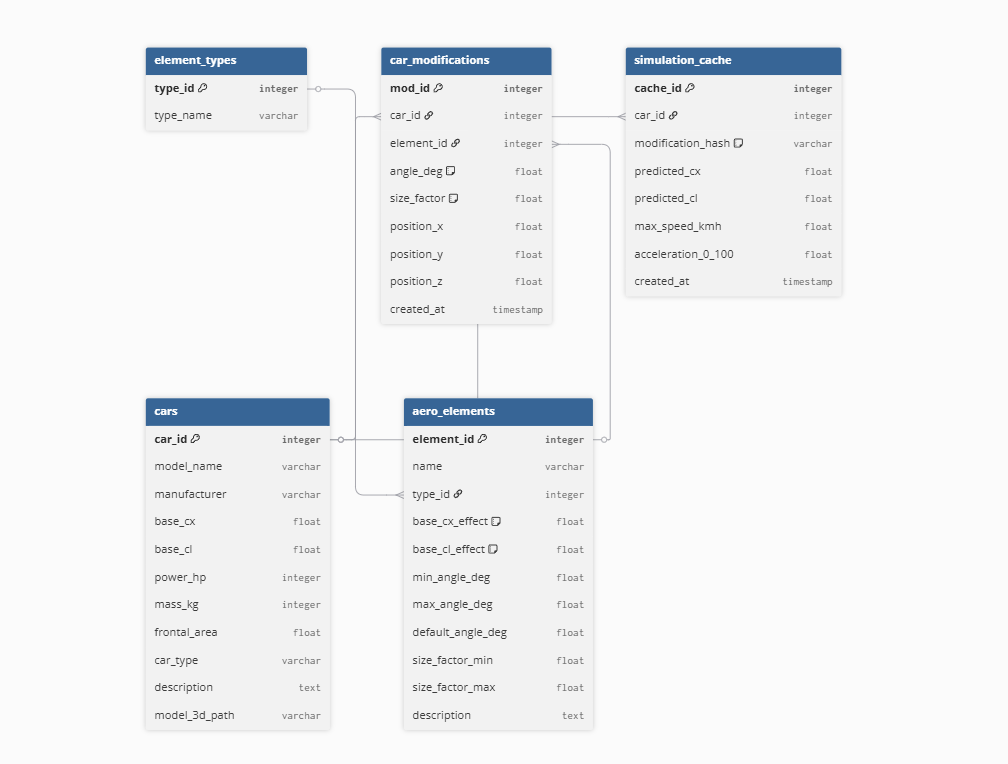

#### **4.3. Пример запроса к базе данных**



**Получение последних анализов пользователя:**

```sql
SELECT
    c.model_name AS автомобиль,
    c.manufacturer AS производитель,
    c.base_cx AS базовый_Cx,
    c.base_cl AS базовый_Cl,
    c.power_hp AS мощность_лс,
    c.mass_kg AS масса_кг,
    
    GROUP_CONCAT(
        CONCAT(
            ae.name, ' (угол: ', cm.angle_deg, '°, масштаб: ', cm.size_factor, ')'
        ) SEPARATOR '; '
    ) AS установленные_модификации,
    
    COUNT(cm.mod_id) AS количество_модификаций

FROM cars c
LEFT JOIN car_modifications cm ON c.car_id = cm.car_id
LEFT JOIN aero_elements ae ON cm.element_id = ae.element_id
WHERE c.car_id = 1
GROUP BY c.car_id;
```

Собирает всю информацию об одном конкретном автомобиле (в данном случае с car_id = 1) и список всех установленных на него аэродинамических элементов, включая:

Название элемента (например, «Задний спойлер Gurney»),
Угол установки (в градусах),
Масштаб (относительный размер).
Если модификаций нет — колонка установленные_модификации будет пустой, но сам автомобиль всё равно отобразится (благодаря LEFT JOIN).